<a href="https://colab.research.google.com/github/tosittig/CASAIS/blob/main/CAS_project4_newsreader_chatbot_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The *Newsreader Chatbot*: news retrieval, summarization and question answering

In this project, you will build a simple chat-based interface for news consumption, the *Newsreader Chatbot*. This chatbot will feature three modules under the hood:
1. a news retrieval system (the corresponding task is generally referred to as **document retrieval**),
2. an automatic summarizer (this task is called **summarization** or **summary generation**),
3. a question-answering system (the task is simply referred to as **question answering** or, in short, **QA**).

In the end, you (the user) will be able to query the *Newsreader Chatbot* with a short sentence indicating the topic you would like to read about. The chatbot will retrieve the most relevant news stories and it will summarise them. You will then be able to select one of the stories and ask questions about it.

The main techniques this project will cover are:
- *Semantic search*, an approach to information retrieval that relies on text embeddings. You will implement two methods, one based on sentence embeddings and the other based on document embeddings.
- *Conditional text generation*, the task of generating a piece of text—for example, a summary or an open-ended answer—given another conditioning piece of text—such as a news story, optionally paired with a question. This task is more generally referred to as Natural Language Generation (NLG) and can serve many use cases, from translation and paraphrasing to storytelling and dialogue response generation. As NLG systems, you will use both general-purpose pre-trained language models and language models specifically fine-tuned on summarization or question answering. You will compare different models using standard NLG evaluation metrics.


----
Before getting started, let's change the Runtime type to `T4 GPU` (only if you are in Google Colab, using the dropdown menu on the top right). Let's also install and load the necessary libraries and define convenience functions.

In [ ]:
# @title Install libraries
# @markdown Please execute this cell.

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

!pip install -U transformers datasets sentencepiece accelerate evaluate rouge_score bert_score sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-n

In [ ]:
## Generic libraries

# Dataframes
import pandas as pd

# Scientific computing
import numpy as np

# PyTorch, a machine learning framework
import torch

# Basic Python tools
import itertools
from collections import defaultdict

# Pretty printing
import textwrap

# A smart progress meter
from tqdm.notebook import trange, tqdm


## Project-specific libraries

# Evaluation metrics (for document retrieval)
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Spacy, a multi-use NLP library -- here, for sentence segmentation
from spacy.lang.en import English

# A library for sentence embeddings
from sentence_transformers import SentenceTransformer, util


## HuggingFace libraries

# A library for easy-to-use Transformer language models (and more)
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration, BartForConditionalGeneration, BartTokenizer, AutoModelForQuestionAnswering

# A library for ready-to-use NLP evaluation metrics
import evaluate

# A library to easily import datasets from the HuggingFace hub
from datasets import load_dataset


In [ ]:
# @title Convenience function for pretty printing
# @markdown Please execute this cell.

def pprint(string, width=120):
  print(textwrap.fill(string, width=width))

## News data: preliminary analysis

We have compiled a dataset of over 10,000 CNN news articles for the purpose of this project. It is available through the Hugging Face dataset hub for extra ease of use: [news-qa-summarization](https://huggingface.co/datasets/glnmario/news-qa-summarization). Each article in the dataset is annotated by humans with a summary as well as a list of questions and corresponding answers. We are going to use this dataset for the development and evaluation of the three submodules of the *Newsreader Chatbot*.

Let's load the dataset.

In [ ]:
dataset = load_dataset("glnmario/news-qa-summarization")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

The dataset contains a single partition, which is called `train` by default, and consists of four fields:
- `story`: the news story
- `questions`: a list of questions regarding the news story
- `answers`: the list of answers to `questions`
- `summary`: a brief summary of the news story

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['story', 'questions', 'answers', 'summary'],
        num_rows: 10388
    })
})

Let's take a look at one data point.

In [ ]:
# The news story
pprint(dataset['train'][1]['story'])

(AOL Autos)  -- At the 2009 Detroit Auto Show, Chrysler, Mercedes-Benz, Toyota and MINI showed the world what electric
vehicles of the future will look like. And the future of driving looks fun. The Dodge Circuit EV can blast from 0-to-60
mph in around 4 seconds. Those in the know realize that sometime in the future, the vast majority of light cars and
trucks in the US will feature electric final drive systems. The motors used in these systems will be powered by
batteries, fuel cells, on-board generators, and perhaps even the sun. But this open issue doesn't change the
inevitability of this reality. Given our current economic times, reality demands practical, tangible, and achievable
ideas of what electric vehicles (or "EVs" for short) might actually look like. This is it ... Chrysler Three of the four
electric vehicles Chrysler showed in Detroit, Michigan, were shown at other events and even to Washington bureaucrats.
Each of these vehicles is a running prototype, not some pie-in-the-

In [ ]:
# The list of questions
dataset['train'][1]['questions']

['What debuts at the 2009 Detroit Auto Show?',
 'Who shows electric cars?',
 'Where is the Detroit Auto Show located?']

In [ ]:
# The corresponding answers
dataset['train'][1]['answers']

[['electric vehicles'],
 ['Chrysler, Mercedes-Benz, Toyota and MINI'],
 ['Michigan,']]

***Write code to print out the summary.***

In [ ]:
# The summary
print(dataset['train'][1]['summary'])

Latest technologies debut at the 2009 Detroit Auto Show .
Chrysler, Mercedes-Benz, Toyota and MINI show what electric cars of future will be .
Toyota confirms plans to add as many as 10 new gas/electric hybrid vehicles .
The "charged" MINI E can run up to 150 miles on a full battery pack .


For a more user-friendly dataset exploration, you can use the Hugging Face dataset hub: [news-qa-summarization](https://huggingface.co/datasets/glnmario/news-qa-summarization).

## News retrieval (semantic search)

We will start by implementing a document retrieval system based on *semantic search*. Given a database of documents—in our case, news stories—this system takes in as input a natural language query and outputs a short list of documents matching that query.

Roughly, a semantic search system works as follows:

1. All the documents in the database are transformed and stored as *document embeddings*, that is, vectors of real numbers that represent the content of documents in an abstract, high-dimensional meaning space. (You can think of these as the document-level equivalent of the word embeddings from Project 3.)
2. When a user produces a query, the text of the query, too, is embedded in the same abstract meaning space, producing a *query embedding*.
3. The documents in the database are ranked according to the geometric (semantic) distance between their respective document embeddings and the query embedding.

We will test two retrieval methods: one with paragraph-level embeddings and one with sentence-level embeddings. These two methods vary with respect to how document embeddings are created.


**Data.** To develop and evaluate the news retrieval system, we will use news stories as documents and questions as queries. *Run the following cell to create a dataset class.*

In [ ]:
# @title RetrievalDataset class
# @markdown Please execute this cell.
class RetrievalDataset:

  def __init__(self, dataset, num_documents=None):
    self.dataset = dataset

    if num_documents:
      self.num_documents = num_documents
      self.documents = self.dataset['train']['story'][:self.num_documents]
      self.queries = list(itertools.chain.from_iterable(self.dataset['train']['questions'][:self.num_documents]))
      self.num_queries = len(self.queries)
    else:
      self.documents = self.dataset['train']['story']
      self.queries = list(itertools.chain.from_iterable(self.dataset['train']['questions']))
      self.num_documents = len(self.documents)
      self.num_queries = len(self.queries)

    self.true_indices = []
    for i, qs in enumerate(self.dataset['train']['questions'][:self.num_documents]):
      for _ in qs:
        self.true_indices.append(i)


Let's construct the retrieval dataset using stories as documents and questions as queries. Use only a subset of the news stories (e.g., `num_documents = 500`) as a development set for more manageable runtimes.



In [ ]:
retrieval_dataset = RetrievalDataset(dataset, num_documents=100)

**Model**. To transform texts (documents or sentences) into embeddings, you will take the nowadays standard approach of using a Transformer language model. For example, you can use the [`multi-qa-MiniLM-L6-cos-v1`](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1) Sentence Transformer.

In [ ]:
# Load the language model
model_name = "multi-qa-MiniLM-L6-cos-v1"
model = SentenceTransformer(model_name)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Paragraph-level embeddings

The first method will rely on paragraph-level embeddings. That is, an entire paragraph (e.g., a whole news story) is passed as an input to a language model, the contextualised word embeddings produced by the language model for all the words in the paragraph are extracted, and the average embedding is taken to be the document representation. Luckily, the SentenceTransformer library used in the cell above automates this process for us.


First, we embed the news stories.

In [ ]:
story_embeddings = model.encode(retrieval_dataset.documents)

Then, we embed an example query.

In [ ]:
query_embedding = model.encode('electric vehicles')

Now we can compute the similarity between the query and the story embeddings. We will use the dot product between embedding as a measure of their geometric distance.

***Fill in the code below by providing the right arguments to the `dot_score` function.***

In [ ]:
# Compute semantic similarity as the dot product between embeddings
similarity_scores = util.dot_score(
story_embeddings,
query_embedding
)

Let's inspect the shape and content of the similarity score vector.

In [ ]:
print(similarity_scores.shape)
print(similarity_scores)

torch.Size([100, 1])
tensor([[-3.5164e-02],
        [ 7.4932e-01],
        [ 4.2309e-01],
        [ 3.4363e-01],
        [ 2.5842e-01],
        [ 1.6174e-01],
        [ 2.6499e-01],
        [ 2.1440e-01],
        [ 1.2893e-01],
        [ 3.4044e-01],
        [ 1.5525e-01],
        [ 4.4081e-01],
        [ 1.7460e-01],
        [ 3.7609e-02],
        [ 2.3579e-01],
        [ 2.3579e-01],
        [ 1.6344e-01],
        [ 4.0172e-01],
        [ 1.2528e-01],
        [ 2.2745e-01],
        [ 3.6874e-01],
        [ 2.8882e-01],
        [ 2.2444e-01],
        [ 3.4821e-01],
        [ 2.1760e-01],
        [ 3.3167e-01],
        [ 4.9821e-01],
        [ 3.8450e-01],
        [ 3.9013e-01],
        [ 1.5539e-01],
        [ 3.8754e-01],
        [ 3.4203e-01],
        [ 2.8183e-01],
        [ 1.9025e-01],
        [ 3.4600e-01],
        [ 3.4600e-01],
        [ 3.2337e-01],
        [-1.0555e-01],
        [-4.2203e-02],
        [ 3.2657e-02],
        [ 1.3123e-01],
        [ 6.5636e-02],
        [ 6.0

Next, we obtain the indices of the top 3 ranked documents and their respective similarity scores. These are the documents that best match the query according to our paragraph embeddings.

In [ ]:
# Get the indices of the 3 top ranked documents and their similarity scores
#top_k_scores, top_k_indices = torch.topk(similarity_scores[0], 3, dim=0)

top_k_scores, top_k_indices = torch.topk(similarity_scores[:, 0], k=3, dim=0)

print(f'Top 3 document ids: {top_k_indices}')
print(f'Top 3 document similarity scores: {top_k_scores}')


Top 3 document ids: tensor([ 1, 26, 11])
Top 3 document similarity scores: tensor([0.7493, 0.4982, 0.4408])


In [ ]:
# Print the best matching document
print('Best matching document:\n')
best_match_index = top_k_indices[0]
pprint(retrieval_dataset.documents[best_match_index])

Best matching document:

(AOL Autos)  -- At the 2009 Detroit Auto Show, Chrysler, Mercedes-Benz, Toyota and MINI showed the world what electric
vehicles of the future will look like. And the future of driving looks fun. The Dodge Circuit EV can blast from 0-to-60
mph in around 4 seconds. Those in the know realize that sometime in the future, the vast majority of light cars and
trucks in the US will feature electric final drive systems. The motors used in these systems will be powered by
batteries, fuel cells, on-board generators, and perhaps even the sun. But this open issue doesn't change the
inevitability of this reality. Given our current economic times, reality demands practical, tangible, and achievable
ideas of what electric vehicles (or "EVs" for short) might actually look like. This is it ... Chrysler Three of the four
electric vehicles Chrysler showed in Detroit, Michigan, were shown at other events and even to Washington bureaucrats.
Each of these vehicles is a running protot

#### Putting it all together

Now that we have tested all of its components, we can reate a Python class for the document retriever based on paragraph-level document embeddings.

***Fill in the code in the cell below.***

In [ ]:
class ParagraphEmbeddingRetriever:

  # Initialise the Retriever object
  # with a document database and a language model
  def __init__(
      self,
      documents,  # the list of documents in the database
      model_name,  # the name of the language model
    ):

    # Load language model
    self.model = SentenceTransformer(
        model_name
    )

    # Embed documents
    print('Initialization: embedding documents...')
    self.doc_embeddings = self.model.encode(
        documents
    )

  # Retrieving function: it takes as input a query and returns
  # the top_k (default top_k = 3) matching documents in the database
  def retrieve(
      self,
      query,
      top_k=3
    ):

    # Embed query
    query_embedding = self.model.encode(
    query
    )

    # Compute semantic similarity
    similarity_scores = util.dot_score(
        query_embedding,
        self.doc_embeddings
    )[0]

    # Get top k documents and their similarity scores
    top_k_scores, top_k_indices = torch.topk(
        similarity_scores,
        k=top_k
    )
    return top_k_indices, top_k_scores, similarity_scores


### ParagraphEmbeddingRetriever
The class is initialized with two parameters:
*   documents, which represents the list of documents in the database
*   model_name, which is the name of the language model



###init
With this method, the language model specified by model_name is loaded using SentenceTransformer.

The encode method of the loaded model is then used to embed the documents, resulting in doc_embeddings, which stores the embeddings for each document in the database.

### retrieve
This function takes a query and a parameter top_k (defaulting to 3) indicating the number of top matching documents to retrieve.

Inside the function:
*   The query is embedded using the same model used for embedding documents.
*   Semantic similarity scores between the query embedding and document embeddings are computed using dot product similarity.
*   The top-k documents and their similarity scores are obtained using torch.topk().

Finally, the function returns the indices of the top-k documents, their similarity scores, and the similarity scores for all documents in the database.

Let's test our compiled document retriever on the previous example.

In [ ]:
paragraph_retriever = ParagraphEmbeddingRetriever(
    documents=retrieval_dataset.documents,
    model_name='multi-qa-MiniLM-L6-cos-v1'
)

top_3_indices, top_3_scores, _ = paragraph_retriever.retrieve(
    query='electric vehicles',
    top_k=3
)

print()
print(f'Top 3 indices: {top_3_indices.tolist()}')
print(f'Their scores: {top_3_scores.tolist()}')
print('\nBest matching document:\n')

best_match_index = top_3_indices[0]
pprint(retrieval_dataset.documents[best_match_index])


Initialization: embedding documents...

Top 3 indices: [1, 26, 11]
Their scores: [0.7493171691894531, 0.4982050955295563, 0.44080573320388794]

Best matching document:

(AOL Autos)  -- At the 2009 Detroit Auto Show, Chrysler, Mercedes-Benz, Toyota and MINI showed the world what electric
vehicles of the future will look like. And the future of driving looks fun. The Dodge Circuit EV can blast from 0-to-60
mph in around 4 seconds. Those in the know realize that sometime in the future, the vast majority of light cars and
trucks in the US will feature electric final drive systems. The motors used in these systems will be powered by
batteries, fuel cells, on-board generators, and perhaps even the sun. But this open issue doesn't change the
inevitability of this reality. Given our current economic times, reality demands practical, tangible, and achievable
ideas of what electric vehicles (or "EVs" for short) might actually look like. This is it ... Chrysler Three of the four
electric vehicles

### Sentence-level embeddings

News stories consist of many sentences. When a single embedding is used to represent them all, the meaning of each sentence is diluted and the final document embedding may become uninformative.

The second method you will implement tries to address this issue by representing documents as a set of sentence-level embeddings. It is more computationally expensive, but it can potentially lead to more accurate retrieval.

The method works as follows:
1. Every document in the database is split into sentences.
2. Each sentence in a document is embedded using a language model, and all the sentence embeddings extracted for a document are stored.
3. At retrieval time, the query text is embedded and compared to all of the sentence embeddings of each document. Instead of a single similarity score for a given document, this results in a list of similarity scores, one for each sentence in the document.
4. To obtain a single number from this list of similarity scores, a summary statistic is used, such as the mean, minimum or maximum.
5. The documents are ranked based on this summary similarity score.

We can reuse the same language model as an embedding engine.

***Write a line of code to load the Sentence Transformer.***

In [ ]:
model_name = "multi-qa-MiniLM-L6-cos-v1"
model = SentenceTransformer(model_name)

To split documents into sentences, we will use the [spaCy](https://spacy.io/) library with its `sentencizer`, or *sentence segmentation* algorithm.

By using spaCy's sentencizer, the document is split into sentences accurately, considering factors such as punctuation and sentence boundaries. This will facilitate embedding each sentence separately for sentence-level retrieval tasks.

In [ ]:
spacy = English()
spacy.add_pipe("sentencizer")

def split(text):
  """
  Splits a text into sentences using the Spacy library.

  Parameters
  ----------
  text : str
      The text to be split into sentences.

  Returns
  -------
  list
      The list of sentences in the text.
  """
  processed_text = spacy(text)
  processed_sentences = processed_text.sents

  sentences = []
  for sentence in processed_sentences:
    sentences.append(sentence.text)

  return sentences


Let's test the sentence segmentation algorithm.



In [ ]:
split('This is a first test sentence. This is the second test sentence. Will the segmentation algorithm detect all sentences correctly?')

['This is a first test sentence.',
 'This is the second test sentence.',
 'Will the segmentation algorithm detect all sentences correctly?']

Now that the sentence segmentation is in place, let's build the sentence-based document retriever step by step.

***In the cell below, fill in the line to embed the sentences in a story.***

In [ ]:
# Embed news stories

story_embeddings = []

for story in tqdm(retrieval_dataset.documents):

  # Split news story into sentences
  sentences = split(story)

  # Embed sentences
  sentence_embeddings =  model.encode(sentences)

  story_embeddings.append(sentence_embeddings)

  0%|          | 0/100 [00:00<?, ?it/s]


***Fill in the code to embed the query sentence.*** You can use the same query sentence as above, "electric vehicles".

In [ ]:
# Embed test query
query_embedding = model.encode('electric vehicles')

Now we can compute the similarity scores between the query embedding and the sentence embeddings. Remember: this will yield multiple similarity scores for each document, one per sentence. So we will summarise this document-specific list of similarity scores using a summary statistic. Here, we test `mean`, `min`, and `max` as summary statistics.

In [ ]:
# Store the similarity scores obtained with different summary statistics
similarity_scores = {
    'mean': [],
    'max': [],
    'min': []
}

for story_sentence_embeddings in (story_embeddings):
    sentence_similarities = util.dot_score(
        query_embedding,
        story_sentence_embeddings
    )
    similarity_scores['mean'].append(sentence_similarities.mean())
    similarity_scores['min'].append(sentence_similarities.min())
    similarity_scores['max'].append(sentence_similarities.max())


Let's retrieve the top 3 stories and their similarity scores.

***Fill in the line below by providing a value for the parameter $k$.***

In [ ]:
top_3_similarity_scores = dict()
top_3_story_indices = dict()

for summary_statistic in ['mean', 'min', 'max']:
  top_k_scores, top_k_indices = torch.topk(
      torch.as_tensor(similarity_scores[summary_statistic]),
      k = 3
  )
  top_3_similarity_scores[summary_statistic] = top_k_scores, top_k_indices


Let's print out the indices of the top 3 matches based on `mean` sentence similarity.

In [ ]:
top_k_scores_mean, top_k_indices_mean = top_3_similarity_scores['mean']
print(f'Top 3 document ids: {top_k_indices_mean}')
print(f'Top 3 document similarity scores: {top_k_scores_mean}')
print('\nBest matching document:\n')

best_match_index = top_k_indices_mean[0]
pprint(retrieval_dataset.documents[best_match_index])


Top 3 document ids: tensor([ 1, 23, 30])
Top 3 document similarity scores: tensor([0.4343, 0.2930, 0.2875])

Best matching document:

(AOL Autos)  -- At the 2009 Detroit Auto Show, Chrysler, Mercedes-Benz, Toyota and MINI showed the world what electric
vehicles of the future will look like. And the future of driving looks fun. The Dodge Circuit EV can blast from 0-to-60
mph in around 4 seconds. Those in the know realize that sometime in the future, the vast majority of light cars and
trucks in the US will feature electric final drive systems. The motors used in these systems will be powered by
batteries, fuel cells, on-board generators, and perhaps even the sun. But this open issue doesn't change the
inevitability of this reality. Given our current economic times, reality demands practical, tangible, and achievable
ideas of what electric vehicles (or "EVs" for short) might actually look like. This is it ... Chrysler Three of the four
electric vehicles Chrysler showed in Detroit, Michig

***In the nest two cells, write code to inspect the top 3 indices and their scores as well as the best matching document for the `min` and `max` sumamry statistics.***

In [ ]:
top_k_scores_min, top_k_indices_min = top_3_similarity_scores['min']
print(f'Top 3 document ids: {top_k_indices_min}')
print(f'Top 3 document similarity scores: {top_k_scores_min}')
print('\nBest matching document:\n')

best_match_index = top_k_indices_min[0]
pprint(retrieval_dataset.documents[best_match_index])

Top 3 document ids: tensor([11, 30, 31])
Top 3 document similarity scores: tensor([0.0815, 0.0447, 0.0440])

Best matching document:

(AOL Autos) -- Consumer Reports recently announced its annual used cars ratings, and we weren't surprised to see one of
the major categories was "Best in Fuel Economy."   With gasoline and oil prices on a seemingly endless upward spiral,
that's a key factor these days when choosing a used car -- or even a new one.   The cars that made this list were,
according to Consumer Reports, "the affordable and reliable vehicles [that] returned some of the best results in our
real-world fuel-economy tests."   What follows is a list of the vehicles that magazine rated "Best in Fuel Economy" in
the under $10,000 price range, with a short description of each vehicle. The mileage figures stated are the ones
calculated by Consumer Reports in their own on-the-road tests.   2000 Honda Insight  Overall MPG: 51   When the Insight
hit showrooms in 1999 for the 2000 model yea

In [ ]:
top_k_scores_max, top_k_indices_max = top_3_similarity_scores['max']
print(f'Top 3 document ids: {top_k_indices_max}')
print(f'Top 3 document similarity scores: {top_k_scores_max}')
print('\nBest matching document:\n')

best_match_index = top_k_indices_min[0]
pprint(retrieval_dataset.documents[best_match_index])

Top 3 document ids: tensor([ 1, 26,  2])
Top 3 document similarity scores: tensor([0.7618, 0.5786, 0.4867])

Best matching document:

(AOL Autos) -- Consumer Reports recently announced its annual used cars ratings, and we weren't surprised to see one of
the major categories was "Best in Fuel Economy."   With gasoline and oil prices on a seemingly endless upward spiral,
that's a key factor these days when choosing a used car -- or even a new one.   The cars that made this list were,
according to Consumer Reports, "the affordable and reliable vehicles [that] returned some of the best results in our
real-world fuel-economy tests."   What follows is a list of the vehicles that magazine rated "Best in Fuel Economy" in
the under $10,000 price range, with a short description of each vehicle. The mileage figures stated are the ones
calculated by Consumer Reports in their own on-the-road tests.   2000 Honda Insight  Overall MPG: 51   When the Insight
hit showrooms in 1999 for the 2000 model yea

Do the different strategies produce different results?

Same results for the top 3 matches based on different summary statistics (mean, min, max) would suggests that the similarity scores across different summary statistics are very similar or identical. This could happen if the range of similarity scores is limited or if the distribution of scores is similar across different summary statistics.

In [ ]:
for summary_statistic in ['mean', 'min', 'max']:
    print(f"Top 3 matches based on '{summary_statistic}' sentence similarity:")
    top_k_scores, top_k_indices = top_3_similarity_scores[summary_statistic]
    for score, idx in zip(top_k_scores, top_k_indices):
        print(f"Score: {score}, Index: {idx}")

Top 3 matches based on 'mean' sentence similarity:
Score: 0.43427833914756775, Index: 1
Score: 0.2929617762565613, Index: 23
Score: 0.28748688101768494, Index: 30
Top 3 matches based on 'min' sentence similarity:
Score: 0.08152081072330475, Index: 11
Score: 0.044694576412439346, Index: 30
Score: 0.04402316361665726, Index: 31
Top 3 matches based on 'max' sentence similarity:
Score: 0.7618287205696106, Index: 1
Score: 0.5786058902740479, Index: 26
Score: 0.48666900396347046, Index: 2


This indicates that each summary statistic (mean, min, max) is capturing different aspects of the similarity distribution.

#### Putting it all together

Now that we have tested all of its components, we can reate a Python class for the document retriever based on on sentence-level document embeddings.

***Fill in the code in the cell below.***

In [ ]:
# SentenceEmbeddingRetriever class

class SentenceEmbeddingRetriever:

  # Initialise the Retriever object
  # with a document database and a language model
  def __init__(
      self,
      documents,
      model_name,
    ):

    # Load language model
    self.model = SentenceTransformer(
        model_name
    )

    # Load the sentence segmentation algorithm
    self.spacy = English()
    self.spacy.add_pipe("sentencizer")

    # Define function to split document into sentences
    def _split(document):
      return [sent.text for sent in self.spacy(document).sents]

    # Embed documents
    self.document_embeddings = []
    print('Initialization: embedding documents...')
    for document in tqdm(documents):

      # Split document into sentences
      sentences = _split(
          document
      )

      # Embed sentences
      sentence_embeddings = self.model.encode(
          sentences
      )

      self.document_embeddings.append(sentence_embeddings)


  # Retrieving function: it takes as input a query and returns
  # the top_k (default top_k = 3) matching documents in the database
  def retrieve(
      self,
      query,
      mode,
      top_k=3
  ):

    # Embed query
    query_embedding = self.model.encode(
       query
    )

    # Compute sentence-level similarity scores
    similarity_scores = []
    for doc_sentence_embeddings in self.document_embeddings:
      sentence_similarities = util.dot_score(
          query_embedding,
          doc_sentence_embeddings
      )[0]

      if mode == 'max':
        similarity_scores.append(
            torch.max(sentence_similarities)
        )
      elif mode == 'mean':
        similarity_scores.append(
            torch.mean(sentence_similarities)
        )
      elif mode == 'min':
        similarity_scores.append(
            torch.min(sentence_similarities)
        )

    # Transform scores into a tensor, for compatibility
    similarity_scores = torch.as_tensor(similarity_scores)

    # Get top k documents and their similarity scores
    top_k_scores, top_k_indices = torch.topk(
      similarity_scores,
      k=top_k
    )
    return top_k_indices, top_k_scores, similarity_scores


Now let's test it on the previous example. Use `mode=mean` to define the summary statistic in the `retrieve` function.

***Fill in the code in the cell below.***

In [ ]:
sentence_retriever = SentenceEmbeddingRetriever(documents=retrieval_dataset.documents, model_name='multi-qa-MiniLM-L6-cos-v1')

top_3_indices, top_3_scores, _ = sentence_retriever.retrieve(
    query='electric vehicles',
    mode='mean',
    top_k=3)

print()
print(f'Top 3 indices: {top_3_indices.tolist()}')
print(f'Scores: {top_3_scores.tolist()}')
print('\nBest matching document:\n')

best_match_index = top_3_indices[0].item()
pprint(retrieval_dataset.documents[best_match_index])


Initialization: embedding documents...


  0%|          | 0/100 [00:00<?, ?it/s]


Top 3 indices: [1, 23, 30]
Scores: [0.43427833914756775, 0.2929617762565613, 0.28748688101768494]

Best matching document:

(AOL Autos)  -- At the 2009 Detroit Auto Show, Chrysler, Mercedes-Benz, Toyota and MINI showed the world what electric
vehicles of the future will look like. And the future of driving looks fun. The Dodge Circuit EV can blast from 0-to-60
mph in around 4 seconds. Those in the know realize that sometime in the future, the vast majority of light cars and
trucks in the US will feature electric final drive systems. The motors used in these systems will be powered by
batteries, fuel cells, on-board generators, and perhaps even the sun. But this open issue doesn't change the
inevitability of this reality. Given our current economic times, reality demands practical, tangible, and achievable
ideas of what electric vehicles (or "EVs" for short) might actually look like. This is it ... Chrysler Three of the four
electric vehicles Chrysler showed in Detroit, Michigan, were 

### Evaluation

How to tell whether the sentence-based retriever actually works better than the paragraph-based one? And how to pick the best summary statistic within the sentence-based approach?

To assess and compare models, we will use *accuracy@k* (or *top-k accuracy*) as an evaluation metric. This metric computes the number of times when the correct document is among the top `k` documents retrieved. This is a generalized version of accuracy, with accuracy@1 being equivalent to the standard notion of accuracy (how often the correct document is the top document retrieved). We use it because in practice, in a retrieval scenario, you most likely want to return multiple hits to the user (think of a Google search) so it can be considered sufficient for the target document to be in the top `k`.

How do we know what the target document for a query is? Remember that our dataset includes news, questions, answers, and summaries. To evaluate the news retrieval system, we will use news stories as target documents and take their respective questions as queries.

For each value of `k` in [`1`, `3`, `5`, `10`] and for each model type in [`paragraph`, `sentence_mean`, `sentence_min`, `sentence_max`], we will compute the top-`k` accuracy of that model type and store it for convenience in the following data structure (i.e., you will be replacing all the zeros with actual accuracy scores).

In [ ]:
top_k_accuracy = {
    1: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
    3: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
    5: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
   10: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
}

Let's start from the paragraph-based model.

In [ ]:
paragraph_retriever = ParagraphEmbeddingRetriever(
    documents=retrieval_dataset.documents,
    model_name='multi-qa-MiniLM-L6-cos-v1'
)

# Collect similarity scores for all the queries in the dataset
# (so we can measure top k accuracy for any k we want)
all_similarity_scores = []

for query in retrieval_dataset.queries:
  _, _, similarity_scores = paragraph_retriever.retrieve(
      query=query
  )
  all_similarity_scores.append(similarity_scores)


# Now compute accuracy for each value of k
for k in [1, 3, 5, 10]:
  acc = top_k_accuracy_score(
      retrieval_dataset.true_indices,  # these are the target document indices
      all_similarity_scores,
      k=k
  )

  top_k_accuracy[k]["paragraph"] = acc


Initialization: embedding documents...


Now evaluate the three versions of the sentence-based retriever. We only need to load it once.

In [ ]:
sentence_retriever = SentenceEmbeddingRetriever(
    documents=retrieval_dataset.documents,
    model_name='multi-qa-MiniLM-L6-cos-v1'
)

Initialization: embedding documents...


  0%|          | 0/100 [00:00<?, ?it/s]

***Fill in the missing lines in the cell below.***

In [ ]:
for summary_statistic in ['mean', 'min', 'max']:

  all_similarity_scores = []

  for query in retrieval_dataset.queries:
    _, _, similarity_scores = sentence_retriever.retrieve(
        query=query,
        mode=summary_statistic
    )
    all_similarity_scores.append(similarity_scores)


  # Now compute accuracy for each value of k

  for k in [1, 3, 5, 10]:
    acc = top_k_accuracy_score(
        retrieval_dataset.true_indices,  # these are the target document indices
        all_similarity_scores,
        k=k
    )

    # Store the top-k accuracy score in the top_k_accuracy data structure
    top_k_accuracy[k][f"sentence_{summary_statistic}"] = acc


Let's see how the models fair!

In [ ]:
top_k_accuracy_df = pd.DataFrame(top_k_accuracy)
top_k_accuracy_df

,1,3,5,10
paragraph,0.582278,0.754747,0.805380,0.857595
sentence_mean,0.518987,0.707278,0.778481,0.865506
sentence_min,0.155063,0.305380,0.376582,0.545886
sentence_max,0.664557,0.806962,0.844937,0.906646


**[Optional]** In the experiments above, we picked a language model and kept it fixed. However, the language model is itself an experimental variable—and a very important one, as the choice of language model determines the quality of the embeddings.

Compare the retrieval systems above against systems based on two alternative language models: [`all-MiniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) and [`msmarco-distilbert-base-v4`](https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v4). For the sentence-based model, you don't need to evaluate all three versions. Pick only the one with the summary statistic that performed best.

**[Optional]** ***Write code to reproduce the experiments above using alternative language models.***

In [ ]:
# Reproduce experiments with all-MiniLM_l6-v2
sentence_retriever_aMLM = SentenceEmbeddingRetriever(
    documents=retrieval_dataset.documents,
    model_name='all-MiniLM-L6-v2'
)

paragraph_retriever_aMLM = ParagraphEmbeddingRetriever(
    documents=retrieval_dataset.documents,
    model_name='all-MiniLM-L6-v2'
)

Initialization: embedding documents...


  0%|          | 0/100 [00:00<?, ?it/s]

Initialization: embedding documents...


In [ ]:
top_k_accuracy_aMLM = {
    1: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
    3: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
    5: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
   10: {"paragraph": 0, "sentence_mean": 0, "sentence_min": 0,  "sentence_max": 0},
}

In [ ]:
all_similarity_scores_aMLM = []

for query in retrieval_dataset.queries:
  _, _, similarity_scores = paragraph_retriever_aMLM.retrieve(
      query=query
  )
  all_similarity_scores_aMLM.append(torch.squeeze(similarity_scores))


# Now compute accuracy for each value of k
for k in [1, 3, 5, 10]:
  acc = top_k_accuracy_score(
      retrieval_dataset.true_indices,  # these are the target document indices
      all_similarity_scores_aMLM,
      k=k
  )

  top_k_accuracy[k]["paragraph"] = acc

In [ ]:
for summary_statistic in ['mean', 'min', 'max']:

  all_similarity_scores_aMLM = []

  for query in retrieval_dataset.queries:
    _, _, similarity_scores = sentence_retriever_aMLM.retrieve(
        query=query,
        mode=summary_statistic
    )
    all_similarity_scores_aMLM.append(similarity_scores)


  # Now compute accuracy for each value of k

  for k in [1, 3, 5, 10]:
    acc = top_k_accuracy_score(
        retrieval_dataset.true_indices,  # these are the target document indices
        all_similarity_scores_aMLM,
        k=k
    )

    # Store the top-k accuracy score in the top_k_accuracy data structure
    top_k_accuracy_aMLM[k][f"sentence_{summary_statistic}"] = acc

In [ ]:
top_k_accuracy_df_aMLM = pd.DataFrame(top_k_accuracy_aMLM)
top_k_accuracy_df_aMLM

,1,3,5,10
paragraph,0.000000,0.000000,0.000000,0.000000
sentence_mean,0.545886,0.748418,0.803797,0.873418
sentence_min,0.161392,0.332278,0.420886,0.585443
sentence_max,0.670886,0.827532,0.875000,0.916139


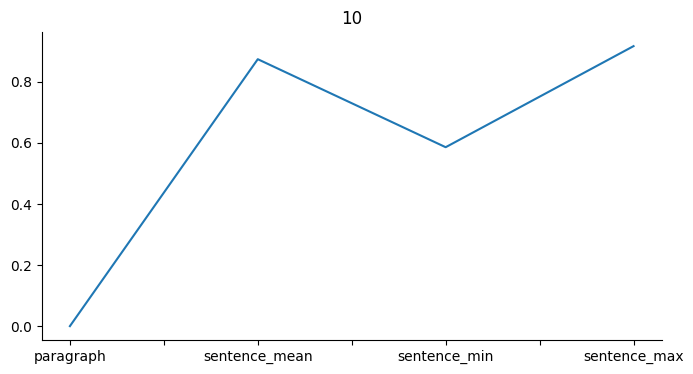

In [ ]:
# @title 10

from matplotlib import pyplot as plt
top_k_accuracy_df_aMLM[10].plot(kind='line', figsize=(8, 4), title=10)
plt.gca().spines[['top', 'right']].set_visible(False)

**[Optional]** In the experiments above, we used news stories as documents and their respective questions as queries. However, it is reasonable to think that summaries might be better proxies of users' queries in some real-world scenarios.


For covenience, we provide a Dataset class analogous to the RetrievalDataset class above

In [ ]:
# @title RetrievalDatasetWithSummaries class
# @markdown Please execute this cell.

class RetrievalDatasetWithSummaries:

  def __init__(self, dataset, num_documents=None):
    self.dataset = dataset

    if num_documents:
      self.num_documents = num_documents
      self.documents = self.dataset['train']['story'][:self.num_documents]
      self.queries = self.dataset['train']['summary'][:self.num_documents]
      self.num_queries = len(self.queries)
    else:
      self.documents = self.dataset['train']['story']
      self.queries = self.dataset['train']['summary']
      self.num_documents = len(self.documents)
      self.num_queries = len(self.queries)

    self.true_indices = []
    for i, qs in enumerate(self.dataset['train']['summary'][:self.num_documents]):
      for _ in qs:
        self.true_indices.append(i)


In [ ]:
retrieval_dataset = RetrievalDatasetWithSummaries(dataset, num_documents=100)

**[Optional]** ***Repeat the experiments above using summaries as queries.***

------

## Summarization

The second module is an automatic summarizer: it takes as input a news story and it generates a short summary.

We will test two types of summarizers:
1. an instruction fine-tuned (multi-task) language model: this is a language model first pre-trained on the next-word prediction task, then fine-tuned on a dataset of instruction-execution pairs for a large variety of tasks
2. a language model fine-tuned specifically for summarization: this is a language model first pre-trained on the next-word prediction task, then fine-tuned on text-summary pairs.


### Instruction fine-tuned summarizer

As a multi-task instruction fine-tuned language model, we will use [`google/flan-t5-large`](https://huggingface.co/google/flan-t5-large).

This model has been trained on 1.8K tasks, including summarization, phrased as instructions.


In [ ]:
model_name_t5 = "google/flan-t5-large"
tokenizer_t5 = T5Tokenizer.from_pretrained(model_name_t5)
model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5, device_map="auto")


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Let's see it at work on a news story!


In [ ]:
test_news_story = dataset["train"][3]["story"]

As this is an instruction fine-tuned model, we can simply kindly ask it to summarize the story in plain words:

In [ ]:
print('Instruction:\n')
input_text = f"Summarize: {test_news_story}"
pprint(input_text)

Instruction:

Summarize: (AOL Autos)  -- Collecting cars is an expensive hobby. Here's a twist: Buy a new car today that will be worth
a fortune as a collectible years from now. The Audi S5 is a slick coupe with solid credentials. Best of all, you don't
need to break the bank to buy a hot and value-appreciating ride. But you do have to be patient, since waiting is key.
"Many consumers could be driving a future collector car right now," McKeel Hagerty, CEO of Hagerty, a specialty insurer
of collector cars in the United States, and himself a respected collector car valuation expert. "Our goal was to find
cars that are currently on the road but may be considered nostalgic in 15 to 20 years. Each car on Hagerty's Hot List
possesses a 'buzz,' a wow factor that resonates with consumers of all ages, many cars being daily drivers that turn
heads already." Why do some vehicles become tomorrow's collector car? Hagerty says it's a combination of pop culture
popularity, limited production numbers 

Now we tokenize the instruction text.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Tokenize input
input_ids = tokenizer_t5(input_text, return_tensors="pt").input_ids.to(device)

Token indices sequence length is longer than the specified maximum sequence length for this model (861 > 512). Running this sequence through the model will result in indexing errors


Then, we generate a summary. We set the minimum and maximum length of the summary to 30 and 100 tokens, respectively.

***Experiment with different minimum and maximum length values by changing the parameters of the `generate` function below.***

In [ ]:
# Generate summary conditioned on instruction and original news story
outputs = model_t5.generate(
    input_ids,
    min_new_tokens=30,   # minimum summary length
    max_new_tokens=100,  # maximum summary length
    do_sample=False      # so we obtain the same sample every time
)

print("Summary:\n")
pprint(tokenizer_t5.decode(outputs[0], skip_special_tokens=True))

Summary:

years from now.


In [ ]:
# Generate summary with a minimum of 20 and a maximim of 80 tokens
outputs = model_t5.generate(
    input_ids,
    min_new_tokens=20,   # minimum summary length
    max_new_tokens=80,  # maximum summary length
    do_sample=False      # so we obtain the same sample every time
)

print("Summary:\n")
pprint(tokenizer_t5.decode(outputs[0], skip_special_tokens=True))

Summary:

years from now.


In [ ]:
# Generate summary with a minimum of 60 and a maximim of 200 tokens
outputs = model_t5.generate(
    input_ids,
    min_new_tokens=60,   # minimum summary length
    max_new_tokens=200,  # maximum summary length
    do_sample=False      # so we obtain the same sample every time
)

print("Summary:\n")
pprint(tokenizer_t5.decode(outputs[0], skip_special_tokens=True))

Summary:

years from now. The Audi S5 is a slick coupe with solid credentials. Best of all, you don't need to break the bank to
buy a hot and value-appreciating ride.


#### Putting it all together

Now that we have tested and understood the components of the summarizer, we can compile them in a Python class.

***Fill in the minimum and maximum length based on your experiments in the cell above.***

In [ ]:
class InstructionFinetunedSummarizer:

  # Initialize model and tokenizer
  def __init__(
      self,
      model_name="google/flan-t5-large",
      device=None
  ):
    self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    self.tokenizer = T5Tokenizer.from_pretrained(model_name)
    self.device = device


  # Summarizing function
  def summarize(self, input_texts):

    # Tokenize texts
    summariser_inputs = []
    for input_text in input_texts:
      summariser_inputs.append(
          self.tokenizer(input_text, return_tensors="pt").input_ids.to(self.device)
      )

    # Generate summaries
    outputs = []
    for input_ids in summariser_inputs:
      outputs.append(
        self.model.generate(
          input_ids,
          min_new_tokens=50,   # set this value by experimenting with the cell above
          max_new_tokens=200,  # set this value by experimenting with the cell above
          do_sample=False
        )[0]
      )

    # Transform token ids into actual words
    summaries = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return summaries

The summarizer is ready! We will evaluate it later, together with the fine-tuned summarizer below.

### Fine-tuned summarizer

As a fine-tuned summarizer, you will use [`facebook/bart-large`](https://huggingface.co/facebook/bart-large-cnn). This is a language model that has been finetuned specifically on summaries of CNN and DailyMail news stories.

Let's load the model using the Hugging Face `pipeline` functionality, which makes the code more concise.

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generate a summary for our test news story.

In [ ]:
test_summary = summarizer(test_news_story)[0]["summary_text"]

print('Summary:\n')
pprint(test_summary)

Summary:

Buy a new car today that will be worth a fortune as a collectible years from now. Cadillac XLR-V Roadster competes with
Mercedes SL-Class, Porsche 911 Cabriolet. Less than 2,000 of the Honda S2000 CR editions will be built. Chevrolet
Corvette Z06 is a fixed-roof coupe with a 7.0-liter V8.


#### Putting it all together

The `pipeline` tool already compiles different components together, but let's define a Python class for this fine-tuned summarizer for extra comfort.

In [ ]:
class FinetunedSummarizer:

  # Initialize model and tokenizer
  def __init__(
      self,
      model_name="facebook/bart-large-cnn",
      device=None
    ):
    self.summarizer = pipeline("summarization", model=model_name, tokenizer=model_name)
    self.device = device
    if self.device is None:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"


  # Summmarizing function
  # It takes texts as input and it returns summaries
  def summarize(self, input_texts):
    outputs = self.summarizer(input_texts)
    summaries = [output["summary_text"] for output in outputs]
    return summaries


### Evaluation

How good are the summaries produced by these two models? Is the fine-tuned model better, as we would probably expect given its task-specific training data?

To assess and compare summarizers, you will use two standard natural language generation (NLG) metrics that are thought to produce good proxies of summary quality:
- **BERTScore**: BERTScore leverages contextualised word embeddings extracted from a pre-trained language model and matches words in candidate and reference sentences by cosine similarity. It has been shown to correlate with human judgment on sentence-level and system-level evaluation. BERTScore can be computed as precision, recall, and F1, which can be useful for evaluating different language generation tasks.
- **ROUGE**: Recall-Oriented Understudy for Gisting Evaluation (ROUGE) is a set of metrics used for evaluating automatic summarization and machine translation. You will use only ROUGE-L, which measures the longest common subsequence between a generated summary and a reference summary.

Both metrics are *reference-based*, i.e., they assess the quality of a summary in terms of its closeness to a reference summary, typically produced by a human. Here, you are going to use the summaries in the dataset as references.

We define convenience functions for the evaluation metrics.

In [ ]:
# @title Evaluation metrics
# @markdown Please execute this cell.

bertscore = evaluate.load("bertscore")
rouge = evaluate.load('rouge')

def evaluate_summaries(predictions, references):

  # Compute BERTScore
  bertscores = bertscore.compute(
      predictions=predictions,
      references=references,
      lang="en"
  )

  # Take the average BERTScore over all summaries
  result_dict = {
      f'bertscore_{stat}': np.mean(bertscores[stat]) for stat in bertscores if stat != 'hashcode'
  }

  # Compute ROUGE (average over all summaries taken automatically)
  rouge_scores = rouge.compute(
      predictions=predictions,
      references=references
  )

  result_dict['rougeL'] = rouge_scores['rougeL']

  return result_dict


#### Model comparison

Let's compare the instruction fine-tuned model against the summarization fine-tuned one using BERTScore and ROUGE.

Load models and data. We will only use a subset of the data to speed up evaluation. *Feel free to use a larger subset, but beware of the longer runtimes.*

In [ ]:
instruction_model = InstructionFinetunedSummarizer()
finetuned_model = FinetunedSummarizer()

dev_set_news_stories = dataset['train']['story'][:30]
dev_set_summaries = dataset['train']['summary'][:30]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generate summaries.

In [ ]:
summaries_instruction = instruction_model.summarize(dev_set_news_stories)
summaries_finetuned = finetuned_model.summarize(dev_set_news_stories)


Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors


Print out the evaluation results.

In [ ]:
instruction_results = evaluate_summaries(summaries_instruction, dev_set_summaries)
finetuned_results = evaluate_summaries(summaries_finetuned, dev_set_summaries)

print('\nInstruction Fine-Tuned Summarizer')
print(instruction_results)

print('\nFine-Tuned Summarizer')
print(finetuned_results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Instruction Fine-Tuned Summarizer
{'bertscore_precision': 0.8404816051324209, 'bertscore_recall': 0.8261332631111145, 'bertscore_f1': 0.8332088430722554, 'rougeL': 0.1252575610371503}

Fine-Tuned Summarizer
{'bertscore_precision': 0.8621936917304993, 'bertscore_recall': 0.8578334132830302, 'bertscore_f1': 0.8599681675434112, 'rougeL': 0.21966795288696606}


#### Evaluating the evaluation metrics

NLG metrics are far from perfect. They act as a proxy for human feedback when this is not available. We well now evaluate the evaluation metrics themselves by testing whether their produced scores correspond to human intuition.

***Evaluate a few summaries produced by the fine-tuned model giving them a score from 1 to 4***, where:
1. the summary doesn't match the content of the story
2. the summary partially matches to content of the story but it doesn't convey the story's main points
3. the summary partially matches the content of the story and it conveys the story's main points
4. the summary matches the content of the story and it conveys the story's main points


Here, we print 5 stories and their respective summaries generated by the summary fine-tuned model. Feel free to evaluate more than 5.

In [ ]:
# feel free to evaluate more than 5 summaries,
# it will give you a better sense of the metrics' flaws
N_manual = 5

for i in range(N_manual):
  pprint(f"STORY {i+1}:\n {dev_set_news_stories[i]}")
  print()
  pprint(f"SUMMARY {i+1}: {summaries_finetuned[i]}")
  print('\n------------------------\n')

STORY 1:  'SINDH KALAY', England (CNN) -- The aroma of freshly baking flatbread wafts through the air as a unit of
British soldiers position themselves for a quick patrol around the village of Sindh Kalay. A British soldier on patrol
in the mock Afghan village of Sindh Kalay. Market vendors hawk grapes and melons, as a group of village elders sit
smoking water pipes and suspicious-looking men lurk beside battered motorcycles. What should the soldiers do? Conduct a
weapons search? Approach the village elders first? In the complex political and cultural terrain of Afghanistan, what is
the best course of action? Except this is not Afghanistan. It's Norfolk, England. Instead of the Hindu Kush mountains,
it is the green ladscape and tidy farmhouses of the English countryside that stretch out behind them. Welcome to the
British Army's state-of-the art training ground. It cost more than $20 million to build and every British soldier
serving in Afghanistan will do his or her training here. "I 

***Provide your scores for the summaries in order in the list below.***

In [ ]:
your_scores = [
    4, 2, 3, 2, 4
]

Now let's see what automatic evaluation scores they get. Do they match your judgements?

In [ ]:
bertscores = bertscore.compute(
  predictions=summaries_finetuned[:N_manual],
  references=dev_set_summaries[:N_manual],
  lang="en"
)

rouge_scores = rouge.compute(
      predictions=summaries_finetuned[:N_manual],
      references=dev_set_summaries[:N_manual],
      use_aggregator=False
)

print('BertScore:')
for score_name, score in bertscores.items():
  print(f'  {score_name}: {score}')

print()
print('Rouge:')
print(f'  {rouge_scores["rougeL"]}')

BertScore:
  precision: [0.8609325885772705, 0.8849539756774902, 0.886622428894043, 0.9028250575065613, 0.857101559638977]
  recall: [0.8654041290283203, 0.8620781898498535, 0.8909502029418945, 0.9097985029220581, 0.8414667248725891]
  f1: [0.8631625771522522, 0.8733662962913513, 0.8887810111045837, 0.9062983989715576, 0.8492121696472168]
  hashcode: roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.39.3)

Rouge:
  [0.29473684210526313, 0.27450980392156865, 0.396039603960396, 0.6037735849056605, 0.1188118811881188]


This is exactly how evaluation metrics are evaluated in NLP research. Human quality judgements are collected and then their correlation with the evaluation metric scores is computed. Here, we do not compute correlations as the number of scores to compare is too low.

------

## [OPTIONAL]  Question Answering

The third module is a Question Answering system: it takes as input a news story and a question and it generates a short answer.

You will test two types of QA systems:
1. an instruction fine-tuned (multi-task) language model
2. a language model fine-tuned specifically for question answering


### Instruction Fine-Tuned

As a multi-task instruction fine-tuned language model, you will again use [`google/flan-t5-large`](https://huggingface.co/google/flan-t5-large). Question answering is among the 1.8K tasks this model was trained on.


In [ ]:
model_name_t5 = "google/flan-t5-large"
tokenizer_t5 = T5Tokenizer.from_pretrained(model_name_t5)
model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5, device_map="auto")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's see it at work on a sample question!


In [ ]:
test_news_story = dataset["train"][1]["story"]

In [ ]:
question = "What will power the motors used in electric cars and trucks?"

Again, as this is an instruction fine-tuned model, we can simply provide it with a news story and ask it a question.

In [ ]:
input_text = f"Context: {test_news_story}\n Question: {question}"  # \n is the newline symbol
input_text

'Context: (AOL Autos)  -- At the 2009 Detroit Auto Show, Chrysler, Mercedes-Benz, Toyota and MINI showed the world what electric vehicles of the future will look like. And the future of driving looks fun. The Dodge Circuit EV can blast from 0-to-60 mph in around 4 seconds. Those in the know realize that sometime in the future, the vast majority of light cars and trucks in the US will feature electric final drive systems. The motors used in these systems will be powered by batteries, fuel cells, on-board generators, and perhaps even the sun. But this open issue doesn\'t change the inevitability of this reality. Given our current economic times, reality demands practical, tangible, and achievable ideas of what electric vehicles (or "EVs" for short) might actually look like. This is it ... Chrysler Three of the four electric vehicles Chrysler showed in Detroit, Michigan, were shown at other events and even to Washington bureaucrats. Each of these vehicles is a running prototype, not some 

Now let's tokenize the instruction text and pass it to the model for conditional generation.

We set the minimum and maximum length of the generated answer to 5 and 30 tokens, respectively.  ***Experiment with different minimum and maximum length values by changing the parameters of the `generate` function below.***

In [ ]:
# Tokenize input
device = "cuda" if torch.cuda.is_available() else "cpu"
input_ids = tokenizer_t5(input_text, return_tensors="pt").input_ids.to(device)

# Generate summary conditioned on instruction and original news story
outputs = model_t5.generate(
    input_ids,
    min_new_tokens=5,   # minimum answer length
    max_new_tokens=30,  # maximum summary length
    do_sample=False     # so we obtain the same sample every time
)

pprint(tokenizer_t5.decode(outputs[0], skip_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (893 > 512). Running this sequence through the model will result in indexing errors


batteries, fuel cells, on-board generators, and perhaps even the sun


#### Putting it all together

Now that we have tested and understood the components of the QA system, we can compile them in a Python class.

***Fill in the minimum and maximum length based on your experiments in the cell above.***

In [ ]:
class InstructionFinetunedQA:

  # Initialize model and tokenizer
  def __init__(
    self,
    model_name="google/flan-t5-large",
    device=None
  ):
    self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    self.tokenizer = T5Tokenizer.from_pretrained(model_name)
    self.device = device
    if self.device is None:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"



  # Question answering function
  # It takes as input multiple texts and multiple questions
  # (one per text) and it returns the corresponding answers
  def qa(self, input_texts, questions):
    assert len(input_texts) == len(questions)

    # Tokenize input text: news stories and questions
    qa_inputs = []
    for text, question in zip(input_texts, questions):
      qa_inputs.append(
        self.tokenizer(
          f"Context: {text}\n Question: {question}",
          return_tensors="pt"
        ).input_ids.to(self.device)
      )

    # Generate answers
    outputs = []
    for qa_input in qa_inputs:
      outputs.append(
        self.model.generate(
          qa_input,
          min_new_tokens=20,   # set this value by experimenting with the cell above
          max_new_tokens=50,  # set this value by experimenting with the cell above
          do_sample=False
        )[0]
      )

    # Transform token ids into actual words
    answers = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return answers



### Fine-tuned QA

As a fine-tuned summarizer, you will use [`deepset/roberta-base-squad2`](https://huggingface.co/deepset/roberta-base-squad2). This is a language model fine-tuned on question-answer pairs.

In [ ]:
model_name_qa = "deepset/roberta-base-squad2"
qa_pipeline = pipeline('question-answering', model=model_name_qa, tokenizer=model_name_qa)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Let's test it on the same question as above.

In [ ]:
test_news_story = dataset["train"][1]["story"]
question = "What will power the motors used in electric cars and trucks?"

Here, we need to provide text and question in a dictionary but they are used as a single string of text under the hood, just like before. After all, this is a language model too.

In [ ]:
qa_input = {
    'question': question,
    'context': test_news_story
}

qa_output = qa_pipeline(qa_input)

pprint(qa_output['answer'])

batteries, fuel cells, on-board generators, and perhaps even the sun


#### Putting it all together

Let's compile the fine-tuned QA system into a Python class for ease of use.

In [ ]:
class FinetunedQA:

  # Initialize model and tokenizer
  def __init__(
    self,
    model_name="deepset/roberta-base-squad2",
    device=None
  ):
    self.qa_pipeline = pipeline('question-answering', model=model_name, tokenizer=model_name)
    self.device = device
    if self.device is None:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"



  # Question answering function
  # It takes as input multiple texts and multiple questions
  # (one per text) and it returns the corresponding answers
  def qa(self, input_texts, questions):
    assert len(input_texts) == len(questions)

    # Prepare input: texts + questions
    qa_inputs = []
    for text, question in zip(input_texts, questions):
      qa_inputs.append({
        'context': text,
        'question': question
      })

    # Generate answers
    outputs = self.qa_pipeline(qa_inputs)

    # Deal with the special case where only one
    # text-question pair is provided as input
    if type(outputs) is dict:
      answers = outputs["answer"]
    else:
      answers = [output["answer"] for output in outputs]

    return answers


### Evaluation


How good are the questions produced by these two models? Is the fine-tuned model better?

To assess and compare QA systems, you will use two reference-based NLG evaluation metrics:
- **BERTScore**: Remember, BERTScore leverages contextualised word embeddings extracted from a pre-trained language model and matches words in candidate and reference sentences by cosine similarity. It is a general way to measure the similarity between two pieces of text, so it be useful for evaluating different language generation tasks.
- **Exact Match**: Because answers are typically short, it is reasonable to expect them to exactly match the human reference. This is what Exact Match does: it is 1 when the generated answer matches the reference, and 0 otherwise. We will report the relative amount of exact matches across all question-answer pairs.


In [ ]:
# @title Evaluation metrics
# @markdown Please execute this cell.

bertscore = evaluate.load("bertscore")
exact_match = evaluate.load('exact_match')

def evaluate_qa(predictions, references):

   # Compute BERTScore
  bertscores = bertscore.compute(
      predictions=predictions,
      references=references,
      lang="en"
  )

  # Take the average BERTScore over all summaries
  result_dict = {
      f'bertscore_{stat}': np.mean(bertscores[stat]) for stat in bertscores if stat != 'hashcode'
  }

  # Compute percentage of exact matches
  exact_match_scores = exact_match.compute(predictions=predictions, references=references)

  result_dict['exact_match'] = exact_match_scores['exact_match']

  return result_dict

#### Model comparison

Let's compare the instruction fine-tuned model against the fine-tuned one.

Load the models.

In [ ]:
torch.set_default_device('cuda')

instruction_model = InstructionFinetunedQA()
finetuned_model = FinetunedQA()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Load the data. Multiple question-answer pairs are available for each story. For simplicity, you'll only use one.

In [ ]:
dev_set_news_stories = dataset['train']['story']

# For each story, take the first question and first answer only
dev_set_questions = [dataset['train'][i]['questions'][0] for i in range(len(dev_set_news_stories))]
dev_set_answers = [dataset['train'][i]['answers'][0][0] for i in range(len(dev_set_news_stories))]

We'll limit the data to a subset of the original dataset consisting of 30 data points. *Feel free to use a larger subset, but beware of the longer runtimes.*

In [ ]:
dev_set_news_stories = dev_set_news_stories[:30]
dev_set_questions = dev_set_questions[:30]
dev_set_answers = dev_set_answers[:30]

Conditionally generate answers.

In [ ]:
answers_instruction = instruction_model.qa(dev_set_news_stories, dev_set_questions)
answers_finetuned = finetuned_model.qa(dev_set_news_stories, dev_set_questions)


Token indices sequence length is longer than the specified maximum sequence length for this model (904 > 512). Running this sequence through the model will result in indexing errors


Print out the evaluation results.

In [ ]:
print('Instruction Fine-Tuned QA')
print(evaluate_qa(answers_instruction, dev_set_answers))

print()

print('Fine-Tuned QA')
print(evaluate_qa(answers_finetuned, dev_set_answers))

Instruction Fine-Tuned QA


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'bertscore_precision': 0.8352997223536174, 'bertscore_recall': 0.9128853261470795, 'bertscore_f1': 0.8719482402006785, 'exact_match': 0.0}

Fine-Tuned QA
{'bertscore_precision': 0.9482939203580221, 'bertscore_recall': 0.9500339368979136, 'bertscore_f1': 0.9487391332785289, 'exact_match': 0.3333333333333333}


#### Evaluating the evaluation metrics

Evaluate a few answers produced by the fine-tuned model giving them a score from 1 to 4, where:
1. the answer is completely off
2. the answer is partially correct but not fluent
3. the answer is partially correct but fluent
4. the answer is correct and fluent


Here, we print 5 stories and their respective question-answer pairs, generated by both humans and the QA fine-tuned model. Feel free to evaluate more than 5.


In [ ]:
# feel free to evaluate more than 5 generated answers,
# it will give you a better sense of the metrics' flaws
N_manual = 5

for i in range(N_manual):
  pprint(f"STORY {i+1}: {dev_set_news_stories[i]}")
  print()
  pprint(f"QUESTION {i+1}: {dev_set_questions[i]}")
  print()
  pprint(f"GENERATED ANSWER {i+1}: {answers_finetuned[i]}")
  print()
  pprint(f"HUMAN ANSWER {i+1}: {dev_set_answers[i]}")
  print('\n------------------------\n')

STORY 1: 'SINDH KALAY', England (CNN) -- The aroma of freshly baking flatbread wafts through the air as a unit of
British soldiers position themselves for a quick patrol around the village of Sindh Kalay. A British soldier on patrol
in the mock Afghan village of Sindh Kalay. Market vendors hawk grapes and melons, as a group of village elders sit
smoking water pipes and suspicious-looking men lurk beside battered motorcycles. What should the soldiers do? Conduct a
weapons search? Approach the village elders first? In the complex political and cultural terrain of Afghanistan, what is
the best course of action? Except this is not Afghanistan. It's Norfolk, England. Instead of the Hindu Kush mountains,
it is the green ladscape and tidy farmhouses of the English countryside that stretch out behind them. Welcome to the
British Army's state-of-the art training ground. It cost more than $20 million to build and every British soldier
serving in Afghanistan will do his or her training here. "I t

***Provide your scores for the summaries in order in the list below.***

In [ ]:
your_scores = [
    4, 3, 4, 4, 4
]

Now let's see what BERTScores they get. Do they match your judgements?

In [ ]:
bertscores = bertscore.compute(
  predictions=answers_finetuned[:N_manual],
  references=dev_set_answers[:N_manual],
  lang="en"
)

print(f'BertScore: {bertscores}')


BertScore: {'precision': [1.0, 0.8622643947601318, 0.8869928121566772, 0.9440184831619263, 0.962459921836853], 'recall': [1.0, 0.9542268514633179, 0.962049663066864, 0.9721345901489258, 0.9727398753166199], 'f1': [1.0, 0.905917763710022, 0.9229978919029236, 0.9578703045845032, 0.9675726294517517], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.39.3)'}


## The *Newsreader Chatbot*

Finally all three modules are ready and we can assembled them into our *Newsreader Chatbot*. Enjoy!

In [ ]:
class NewsReader:

  def __init__(self, database_size=500, num_retrieved_articles=3):
    self.dataset = load_dataset("glnmario/news-qa-summarization")
    self.articles = self.dataset['train']['story'][:database_size]

    self.summarizer = FinetunedSummarizer()
    self.retriever = SentenceEmbeddingRetriever(self.articles, model_name="multi-qa-MiniLM-L6-cos-v1")
    self.answerer = FinetunedQA()

    self.num_retrieved_articles = num_retrieved_articles


  def _ask_for_article_number_and_show_article(self, message, selected_articles):
    target_article_idx = input(message)
    while target_article_idx not in map(str, range(1, self.num_retrieved_articles+1)):
      target_article_idx = input('\nPlease just enter the article number.\n\n')

    selected_article = selected_articles[int(target_article_idx) - 1]
    pprint(selected_articles[int(target_article_idx) - 1])
    return selected_article


  def chat(self):
    query = input('What news topic do you want to look for?\n\n')
    print(f"\nOk! I am searching and summarizing news stories about {query}...")

    top_indices, top_scores, _ = self.retriever.retrieve(query, top_k=self.num_retrieved_articles, mode='max')
    selected_articles = [self.articles[i] for i in top_indices]
    summaries = self.summarizer.summarize(selected_articles)

    print('These are summaries of the three news stories that best match your search.\n')
    for i, summary in enumerate(summaries, start=1):
      pprint(f'{i}: {summary}')
      print()

    selected_article = self._ask_for_article_number_and_show_article(
        '\nWhich article would you like to read? Please enter the article number.\n\n',
        selected_articles
    )

    question = input('\n\nDo you have any questions?\n\n')
    while question.lower() in ['no', 'no.', 'nope', "i don't", 'i do not']:
      selected_article = self._ask_for_article_number_and_show_article(
          '\nWould you like to read another article? If so, which one? Please enter the article number.\n\n',
          selected_articles
      )
      question = input('\n\nDo you have any questions?\n\n')

    print()
    print(self.answerer.qa([selected_article], [question]))

    question = input('\n\nDo you have another question?\n\n')
    while question.lower() not in ['no', 'no.', 'nope', "i don't", 'i do not']:
      print(self.answerer.qa([selected_article], [question]))
      question = input('\n\nDo you have another question?\n\n')


    print('\nI hope I have been helpful. Talk again soon!')


In [ ]:
bot = NewsReader(database_size=10)
bot.chat()

Initialization: embedding documents...


  0%|          | 0/10 [00:00<?, ?it/s]


Ok! I am searching and summarizing news stories about What is the most frequently sold car in Texas)...
These are summaries of the three news stories that best match your search.

1: Three out of four automotive transactions in the U.S. involve previously owned vehicles. About half the cars that are
flood damaged end up back on the road. The most frequently searched price range for a used vehicle is under $5,000.
There are more used Silverado pickup trucks for sale than any other model.

2: Buy a new car today that will be worth a fortune as a collectible years from now. Cadillac XLR-V Roadster competes
with Mercedes SL-Class, Porsche 911 Cabriolet. Less than 2,000 of the Honda S2000 CR editions will be built. Chevrolet
Corvette Z06 is a fixed-roof coupe with a 7.0-liter V8.

3: Certified Pre-Owned (CPO) programs are operated jointly by the manufacturer and the dealer. The number of items -- or
points -- inspected on the vehicle varies from 100 to 300. Some CPO warranties are transfer